# Demo Workflow

In [1]:
import model_catalogs as mc

import intake
import pandas as pd

import os

## Source catalog

The source catalog is all hard-wired and does not access the actual model files.

In [2]:
cats = mc.Management(make_source_catalog=True)

"complete" model source files are not yet available. Run `.update_source_files()` to create this directory.


In [3]:
list(cats.source_cat)

['NYOFS',
 'CBOFS_REGULARGRID',
 'LMHOFS_REGULARGRID',
 'LEOFS_REGULARGRID',
 'WCOFS_REGULARGRID',
 'RTOFS-EAST',
 'RTOFS-ALASKA',
 'GOMOFS_REGULARGRID',
 'CIOFS_REGULARGRID',
 'NGOFS2_2DS',
 'TBOFS',
 'GFS-1_2DEG',
 'NGOFS2',
 'RTOFS-GLOBAL_2D',
 'GFS-1DEG',
 'SFBOFS_REGULARGRID',
 'HYCOM',
 'RTOFS-GLOBAL',
 'CIOFS',
 'LMHOFS',
 'DBOFS',
 'LEOFS',
 'DBOFS_REGULARGRID',
 'WCOFS_2DS',
 'SFBOFS',
 'GFS-1_4DEG',
 'NGOFS2_REGULARGRID',
 'RTOFS-WEST',
 'TBOFS_REGULARGRID',
 'LOOFS',
 'WCOFS',
 'GOMOFS',
 'CREOFS',
 'GOMOFS_2DS',
 'LSOFS',
 'CBOFS',
 'CREOFS_REGULARGRID']

### Update source model catalog files

At some point, you need to run the following in order to add the domain boundary information to the model catalog files. This will create a new directory of the files called "complete" (as opposed to the original "orig") that include "geospatial_bounds" and "bounding_box" under the catalog-level metadata.

This only needs to be run once. If you want to rerun it, delete the "complete" directory.

In [4]:
cats.update_source_files()

/Users/kthyng/miniconda3/envs/model_catalogs/lib/python3.8/site-packages/alphashape/alphashape.py:112: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(points) < 4 or (alpha is not None and not callable(
/Users/kthyng/projects/LibGOODS/model_catalogs/model_catalogs/model_catalogs.py:106: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  p1 = alphashape.alphashape(pts, alpha)
/Users/kthyng/miniconda3/envs/model_catalogs/lib/python3.8/site-packages/alphashape/alphashape.py:112: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(points) < 4 or (alpha

### Examine metadata of models in source catalog

Now the source catalog has all hard-wired information about the models plus the domain boundary information. This is available in `cats.source_cat`. 

#### Domain boundaries

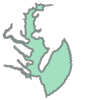

In [5]:
import shapely.wkt

P = shapely.wkt.loads(cats.source_cat['CBOFS'].metadata['geospatial_bounds'])
P

#### Variables

A mapping for the relevant variables to NOAA applications has been written into each source catalog. The mapping is between a standard CF convention variable name to the model dataset variable name. The list of possible variables used is:

        eastward_sea_water_velocity
        eastward_wind
        northward_sea_water_velocity
        northward_wind
        sea_surface_height_above_mean_sea_level
        sea_water_temperature
        sea_water_practical_salinity
        time
        upward_sea_water_velocity

Examine the variable mapping for a given model:

In [6]:
cats.source_cat['CBOFS']['forecast'].metadata['standard_names']

{'eastward_sea_water_velocity': 'u',
 'eastward_wind': 'Uwind',
 'northward_sea_water_velocity': 'v',
 'northward_wind': 'Vwind',
 'sea_surface_height_above_mean_sea_level': 'zeta',
 'sea_water_practical_salinity': 'salt',
 'sea_water_temperature': 'temp',
 'time': 'time',
 'upward_sea_water_velocity': 'w'}

## User catalog

After selecting a model configuration through a GUI or by looking at the source catalog and metadata, the next step is to set up one or more sources in a user catalog. There are multiple ways to input the same information, as shown in the following cells. Also note that `setup_cat` can be run multiple times and each time it will add on the new source(s) to the existing sources.

The source in the user catalog with `_orig` is used by the matching source without `_orig`; use the entry without `_orig`.

### input single model configuration as list of keywords

In [7]:
model = 'CBOFS'
timing = 'nowcast'
start_date = '2022-02-01'

cats.setup_cat(model=model, timing=timing, start_date=start_date, end_date=start_date,
               treat_last_day_as_forecast=False)

list(cats.user_cat)

['CBOFS-nowcast_orig', 'CBOFS-nowcast']

### input single model configuration as dict

In [8]:
cats.setup_cat(
                dict(model='DBOFS', timing='forecast', start_date=None, 
                     end_date=None, treat_last_day_as_forecast=False)
              )
list(cats.user_cat)

['CBOFS-nowcast_orig',
 'CBOFS-nowcast',
 'DBOFS-forecast_orig',
 'DBOFS-forecast']

### input single or multiple model configurations as list of dicts

In [9]:
today = pd.Timestamp.today()
yesterday = today - pd.Timedelta('1 day')

cats.setup_cat([dict(model='DBOFS', 
                          timing='forecast', 
                          start_date=None, 
                          end_date=None,
                          treat_last_day_as_forecast=False),
                     dict(model='DBOFS', timing='nowcast', 
                          start_date=yesterday, end_date=today,
                          treat_last_day_as_forecast=True),
                    ])

list(cats.user_cat)

['CBOFS-nowcast_orig',
 'CBOFS-nowcast',
 'DBOFS-forecast_orig',
 'DBOFS-forecast',
 'DBOFS-nowcast-with_forecast_orig',
 'DBOFS-nowcast-with_forecast']

### NOAA OFS models: how to use filetypes besides default 3D "fields"

All NOAA OFS model configurations are available with 3D fields filetypes. However, for some models there are other filetypes:
* `regular_grid`: model output interpolated to rectilinear grid
* `2ds`: only surface model output, variable names changed

You can see what model configurations are available, specifically including filetypes, by looking at the source catalog:

In [10]:
list(cats.source_cat)

['NYOFS',
 'CBOFS_REGULARGRID',
 'LMHOFS_REGULARGRID',
 'LEOFS_REGULARGRID',
 'WCOFS_REGULARGRID',
 'RTOFS-EAST',
 'RTOFS-ALASKA',
 'GOMOFS_REGULARGRID',
 'CIOFS_REGULARGRID',
 'NGOFS2_2DS',
 'TBOFS',
 'GFS-1_2DEG',
 'NGOFS2',
 'RTOFS-GLOBAL_2D',
 'GFS-1DEG',
 'SFBOFS_REGULARGRID',
 'HYCOM',
 'RTOFS-GLOBAL',
 'CIOFS',
 'LMHOFS',
 'DBOFS',
 'LEOFS',
 'DBOFS_REGULARGRID',
 'WCOFS_2DS',
 'SFBOFS',
 'GFS-1_4DEG',
 'NGOFS2_REGULARGRID',
 'RTOFS-WEST',
 'TBOFS_REGULARGRID',
 'LOOFS',
 'WCOFS',
 'GOMOFS',
 'CREOFS',
 'GOMOFS_2DS',
 'LSOFS',
 'CBOFS',
 'CREOFS_REGULARGRID']

for `CBOFS_REGULARGRID`, what timings are available?

In [11]:
list(cats.source_cat['CBOFS_REGULARGRID'])

['forecast', 'nowcast']

Add a source to the user catalog to demonstrate:

In [12]:
cats.setup_cat(model='CBOFS_REGULARGRID', timing='forecast', start_date=start_date, end_date=start_date,
               treat_last_day_as_forecast=False)

list(cats.user_cat)

['CBOFS-nowcast_orig',
 'CBOFS-nowcast',
 'DBOFS-forecast_orig',
 'DBOFS-forecast',
 'DBOFS-nowcast-with_forecast_orig',
 'DBOFS-nowcast-with_forecast',
 'CBOFS_REGULARGRID-forecast_orig',
 'CBOFS_REGULARGRID-forecast']

Look at the metadata for the source option, and note that the grid information is different from the `CBOFS` `fields` filetype (the default) since it has been interpolated to a rectilinear grid.

In [13]:
cats.user_cat['CBOFS_REGULARGRID-forecast']

CBOFS_REGULARGRID-forecast:
  args:
    targets:
    - CBOFS_REGULARGRID-forecast_orig
    transform: model_catalogs.process.add_attributes
    transform_kwargs:
      axis:
        T: ocean_time
        X: nx
        Y: ny
        Z: Depth
      standard_names:
        eastward_sea_water_velocity: u_eastward
        northward_sea_water_velocity: v_northward
        sea_surface_height_above_mean_sea_level: zeta
        sea_water_practical_salinity: salt
        sea_water_temperature: temp
        time: ocean_time
  description: Catalog entry for transform of dataset CBOFS_REGULARGRID-forecast_orig
  driver: model_catalogs.process.DatasetTransform
  metadata:
    CPP_options: mode, ADD_FSOBC, ADD_M2OBC, ANA_BPFLUX, ANA_BSFLUX, ANA_BTFLUX, ANA_RAIN,
      ANA_SPFLUX, ANA_SSFLUX, ASSUMED_SHAPE, ATM_PRESS, !BOUNDARY_ALLGATHER, BULK_FLUXES,
      !COLLECT_ALL..., CURVGRID, DIFF_GRID, DJ_GRADPS, DOUBLE_PRECISION, EMINUSP,
      GLS_MIXING, HDF5, HYPOXIA_SRM, LIMIT_STFLX_COOLING, KANTHA_CLAYS

## Using model output

### Read in model output

The desired model output source can be accessed from the `user_cat`:

In [14]:
cats.user_cat['CBOFS-nowcast'].to_dask()

<xarray.Dataset>
Dimensions:         (tracer: 3, boundary: 4, s_rho: 20, s_w: 21, eta_rho: 291,
                     xi_rho: 332, eta_u: 291, xi_u: 331, eta_v: 290, xi_v: 332,
                     eta_psi: 290, xi_psi: 331, ocean_time: 24)
Coordinates: (12/19)
  * s_rho           (s_rho) float64 -0.975 -0.925 -0.875 ... -0.075 -0.025
  * s_w             (s_w) float64 -1.0 -0.95 -0.9 -0.85 ... -0.15 -0.1 -0.05 0.0
    lon_rho         (eta_rho, xi_rho) float64 dask.array<chunksize=(291, 332), meta=np.ndarray>
    lat_rho         (eta_rho, xi_rho) float64 dask.array<chunksize=(291, 332), meta=np.ndarray>
    lon_u           (eta_u, xi_u) float64 dask.array<chunksize=(291, 331), meta=np.ndarray>
    lat_u           (eta_u, xi_u) float64 dask.array<chunksize=(291, 331), meta=np.ndarray>
    ...              ...
  * xi_v            (xi_v) int64 0 1 2 3 4 5 6 7 ... 325 326 327 328 329 330 331
  * xi_psi          (xi_psi) int64 0 1 2 3 4 5 6 ... 324 325 326 327 328 329 330
  * eta_rho         (eta_rho) int64 0 1 2 3 4 5 6 ... 285 286 287 288 289 290
  * eta_u           (eta_u) int64 0 1 2 3 4 5 6 ... 284 285 286 287 288 289 290
  * eta_v           (eta_v) int64 0 1 2 3 4 5 6 ... 283 284 285 286 287 288 289
  * eta_psi         (eta_psi) int64 0 1 2 3 4 5 6 ... 284 285 286 287 288 289
Dimensions without coordinates: tracer, boundary
Data variables: (12/97)
    ntimes          int32 ...
    ndtfast         int32 ...
    dt              float64 ...
    dtfast          float64 ...
    dstart          datetime64[ns] ...
    nHIS            int32 ...
    ...              ...
    temp            (ocean_time, s_rho, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 20, 291, 332), meta=np.ndarray>
    salt            (ocean_time, s_rho, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 20, 291, 332), meta=np.ndarray>
    oxygen          (ocean_time, s_rho, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 20, 291, 332), meta=np.ndarray>
    Pair            (ocean_time, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 291, 332), meta=np.ndarray>
    Uwind           (ocean_time, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 291, 332), meta=np.ndarray>
    Vwind           (ocean_time, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 291, 332), meta=np.ndarray>
Attributes: (12/37)
    file:                            nos.cbofs.fields.nowcast.20220201.t00z_0...
    format:                          netCDF-4/HDF5 file
    Conventions:                     CF-1.4, SGRID-0.3
    type:                            ROMS/TOMS history file
    title:                           cbofs nowcast RUN in operational mode
    var_info:                        varinfo.dat
    ...                              ...
    history:                         ROMS/TOMS, Version 3.9, Tuesday - Februa...
    ana_file:                        ROMS/Functionals/ana_btflux.h, ROMS/Func...
    CPP_options:                     mode, ADD_FSOBC, ADD_M2OBC, ANA_BPFLUX, ...
    bio_file:                        ROMS/Nonlinear/Biology/hypoxia_srm.h
    DODS_EXTRA.Unlimited_Dimension:  ocean_time
    EXTRA_DIMENSION.N:               20

Previously read-in model output can be accessed here:

In [15]:
cats.user_cat['CBOFS-nowcast']._ds

<xarray.Dataset>
Dimensions:         (tracer: 3, boundary: 4, s_rho: 20, s_w: 21, eta_rho: 291,
                     xi_rho: 332, eta_u: 291, xi_u: 331, eta_v: 290, xi_v: 332,
                     eta_psi: 290, xi_psi: 331, ocean_time: 24)
Coordinates: (12/19)
  * s_rho           (s_rho) float64 -0.975 -0.925 -0.875 ... -0.075 -0.025
  * s_w             (s_w) float64 -1.0 -0.95 -0.9 -0.85 ... -0.15 -0.1 -0.05 0.0
    lon_rho         (eta_rho, xi_rho) float64 dask.array<chunksize=(291, 332), meta=np.ndarray>
    lat_rho         (eta_rho, xi_rho) float64 dask.array<chunksize=(291, 332), meta=np.ndarray>
    lon_u           (eta_u, xi_u) float64 dask.array<chunksize=(291, 331), meta=np.ndarray>
    lat_u           (eta_u, xi_u) float64 dask.array<chunksize=(291, 331), meta=np.ndarray>
    ...              ...
  * xi_v            (xi_v) int64 0 1 2 3 4 5 6 7 ... 325 326 327 328 329 330 331
  * xi_psi          (xi_psi) int64 0 1 2 3 4 5 6 ... 324 325 326 327 328 329 330
  * eta_rho         (eta_rho) int64 0 1 2 3 4 5 6 ... 285 286 287 288 289 290
  * eta_u           (eta_u) int64 0 1 2 3 4 5 6 ... 284 285 286 287 288 289 290
  * eta_v           (eta_v) int64 0 1 2 3 4 5 6 ... 283 284 285 286 287 288 289
  * eta_psi         (eta_psi) int64 0 1 2 3 4 5 6 ... 284 285 286 287 288 289
Dimensions without coordinates: tracer, boundary
Data variables: (12/97)
    ntimes          int32 ...
    ndtfast         int32 ...
    dt              float64 ...
    dtfast          float64 ...
    dstart          datetime64[ns] ...
    nHIS            int32 ...
    ...              ...
    temp            (ocean_time, s_rho, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 20, 291, 332), meta=np.ndarray>
    salt            (ocean_time, s_rho, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 20, 291, 332), meta=np.ndarray>
    oxygen          (ocean_time, s_rho, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 20, 291, 332), meta=np.ndarray>
    Pair            (ocean_time, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 291, 332), meta=np.ndarray>
    Uwind           (ocean_time, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 291, 332), meta=np.ndarray>
    Vwind           (ocean_time, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 291, 332), meta=np.ndarray>
Attributes: (12/37)
    file:                            nos.cbofs.fields.nowcast.20220201.t00z_0...
    format:                          netCDF-4/HDF5 file
    Conventions:                     CF-1.4, SGRID-0.3
    type:                            ROMS/TOMS history file
    title:                           cbofs nowcast RUN in operational mode
    var_info:                        varinfo.dat
    ...                              ...
    history:                         ROMS/TOMS, Version 3.9, Tuesday - Februa...
    ana_file:                        ROMS/Functionals/ana_btflux.h, ROMS/Func...
    CPP_options:                     mode, ADD_FSOBC, ADD_M2OBC, ANA_BPFLUX, ...
    bio_file:                        ROMS/Nonlinear/Biology/hypoxia_srm.h
    DODS_EXTRA.Unlimited_Dimension:  ocean_time
    EXTRA_DIMENSION.N:               20

### Access variables and axis

Metadata has been added to the model Datasets to facilitate certain variable and axis accessibility. The variable access is set up by adding standard variable names to the datasets when they are opened, based on the variables available, and the axis accessibility is first by adding some attributes and then by using `cf-xarray`. See the following examples.

Filter an xarray Dataset by the attribute of `standard_name` (returns an xarray Dataset):

In [16]:
cats.user_cat['CBOFS-nowcast']._ds.filter_by_attrs(standard_name='sea_water_practical_salinity')

<xarray.Dataset>
Dimensions:     (ocean_time: 24, s_rho: 20, eta_rho: 291, xi_rho: 332)
Coordinates:
  * s_rho       (s_rho) float64 -0.975 -0.925 -0.875 ... -0.125 -0.075 -0.025
    lon_rho     (eta_rho, xi_rho) float64 dask.array<chunksize=(291, 332), meta=np.ndarray>
    lat_rho     (eta_rho, xi_rho) float64 dask.array<chunksize=(291, 332), meta=np.ndarray>
  * ocean_time  (ocean_time) datetime64[ns] 2022-01-31T19:00:00 ... 2022-02-0...
  * xi_rho      (xi_rho) int64 0 1 2 3 4 5 6 7 ... 325 326 327 328 329 330 331
  * eta_rho     (eta_rho) int64 0 1 2 3 4 5 6 7 ... 284 285 286 287 288 289 290
Data variables:
    salt        (ocean_time, s_rho, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 20, 291, 332), meta=np.ndarray>
Attributes: (12/37)
    file:                            nos.cbofs.fields.nowcast.20220201.t00z_0...
    format:                          netCDF-4/HDF5 file
    Conventions:                     CF-1.4, SGRID-0.3
    type:                            ROMS/TOMS history file
    title:                           cbofs nowcast RUN in operational mode
    var_info:                        varinfo.dat
    ...                              ...
    history:                         ROMS/TOMS, Version 3.9, Tuesday - Februa...
    ana_file:                        ROMS/Functionals/ana_btflux.h, ROMS/Func...
    CPP_options:                     mode, ADD_FSOBC, ADD_M2OBC, ANA_BPFLUX, ...
    bio_file:                        ROMS/Nonlinear/Biology/hypoxia_srm.h
    DODS_EXTRA.Unlimited_Dimension:  ocean_time
    EXTRA_DIMENSION.N:               20

Alternatively, you could back out the variable name and use it directly (returns an xarray DataArray):

In [17]:
varname = cats.user_cat['CBOFS-nowcast'].metadata['standard_names']['sea_water_practical_salinity']
cats.user_cat['CBOFS-nowcast']._ds[varname]

<xarray.DataArray 'salt' (ocean_time: 24, s_rho: 20, eta_rho: 291, xi_rho: 332)>
dask.array<concatenate, shape=(24, 20, 291, 332), dtype=float32, chunksize=(1, 20, 291, 332), chunktype=numpy.ndarray>
Coordinates:
  * s_rho       (s_rho) float64 -0.975 -0.925 -0.875 ... -0.125 -0.075 -0.025
    lon_rho     (eta_rho, xi_rho) float64 dask.array<chunksize=(291, 332), meta=np.ndarray>
    lat_rho     (eta_rho, xi_rho) float64 dask.array<chunksize=(291, 332), meta=np.ndarray>
  * ocean_time  (ocean_time) datetime64[ns] 2022-01-31T19:00:00 ... 2022-02-0...
  * xi_rho      (xi_rho) int64 0 1 2 3 4 5 6 7 ... 325 326 327 328 329 330 331
  * eta_rho     (eta_rho) int64 0 1 2 3 4 5 6 7 ... 284 285 286 287 288 289 290
Attributes:
    long_name:      salinity
    time:           ocean_time
    grid:           grid
    location:       face
    field:          salinity, scalar, series
    _ChunkSizes:    [  1  10 146 166]
    standard_name:  sea_water_practical_salinity

Refer to time axis without knowing the time variable name with `cf-xarray`:

In [18]:
cats.user_cat['CBOFS-nowcast']._ds.cf['T']

<xarray.DataArray 'ocean_time' (ocean_time: 24)>
array(['2022-01-31T19:00:00.000000000', '2022-01-31T20:00:00.000000000',
       '2022-01-31T21:00:00.000000000', '2022-01-31T22:00:00.000000000',
       '2022-01-31T23:00:00.000000000', '2022-02-01T00:00:00.000000000',
       '2022-02-01T01:00:00.000000000', '2022-02-01T02:00:00.000000000',
       '2022-02-01T03:00:00.000000000', '2022-02-01T04:00:00.000000000',
       '2022-02-01T05:00:00.000000000', '2022-02-01T06:00:00.000000000',
       '2022-02-01T07:00:00.000000000', '2022-02-01T08:00:00.000000000',
       '2022-02-01T09:00:00.000000000', '2022-02-01T10:00:00.000000000',
       '2022-02-01T11:00:00.000000000', '2022-02-01T12:00:00.000000000',
       '2022-02-01T13:00:00.000000000', '2022-02-01T14:00:00.000000000',
       '2022-02-01T15:00:00.000000000', '2022-02-01T16:00:00.000000000',
       '2022-02-01T17:00:00.000000000', '2022-02-01T18:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * ocean_time  (ocean_time) datetime64[ns] 2022-01-31T19:00:00 ... 2022-02-0...
Attributes:
    long_name:      time since initialization
    field:          time, scalar, series
    _ChunkSizes:    512
    axis:           T
    standard_name:  time